Airbnb price prediction aims to estimate the optimal price for a rental listing based on various factors, helping hosts maximize their earnings while remaining competitive. This involves analyzing data like location, property type, amenities, and market trends to predict the most suitable price point.

In [332]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
warnings.filterwarnings('ignore')
import joblib

In [333]:
!unzip -q /content/AirBnbDataset.zip -d /content/

replace /content/AirBnbDataset/listings_Amsterdam.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [334]:
import pandas as pd

# List of (file_path, city_name) tuples
files_info = [
    ('/content/AirBnbDataset/listings_Paris.csv', 'Paris'),
    ('/content/AirBnbDataset/listings_Rome.csv', 'Rome'),
    ('/content/AirBnbDataset/listings_Amsterdam.csv', 'Amsterdam'),
    ('/content/AirBnbDataset/listings_Berlin.csv', 'Berlin'),
    ('/content/AirBnbDataset/listings_Prague.csv', 'Prague'),
    ('/content/AirBnbDataset/listings_Barcelona.csv', 'Barcelona'),
    ('/content/AirBnbDataset/listings_Budapest.csv', 'Budapest'),
    ('/content/AirBnbDataset/listings_Vienna.csv', 'Vienna'),
    ('/content/AirBnbDataset/listings_Athens.csv', 'Athens'),
    ('/content/AirBnbDataset/listings_Istanbul.csv','Istanbul'),
    ('/content/AirBnbDataset/listings_Dublin.csv','Dublin'),
    ('/content/AirBnbDataset/listings_Oslo.csv','Oslo'),
    ('/content/AirBnbDataset/listings_Stockholm.csv','Stockholm'),
    ('/content/AirBnbDataset/listings_copenhagen.csv','Copenhagen'),
    ('/content/AirBnbDataset/listings_Brussels.csv','Brussels'),
]

# Read and append with city column
df_list = []

for file_path, city in files_info:
    df = pd.read_csv(file_path)
    df['city'] = city  # Add city name
    df_list.append(df)

# Combine all
df = pd.concat(df_list, ignore_index=True)


In [335]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296386 entries, 0 to 296385
Data columns (total 19 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   id                              296386 non-null  int64  
 1   name                            296386 non-null  object 
 2   host_id                         296386 non-null  int64  
 3   host_name                       295298 non-null  object 
 4   neighbourhood_group             33114 non-null   object 
 5   neighbourhood                   296386 non-null  object 
 6   latitude                        296386 non-null  float64
 7   longitude                       296386 non-null  float64
 8   room_type                       296386 non-null  object 
 9   price                           223949 non-null  float64
 10  minimum_nights                  296386 non-null  int64  
 11  number_of_reviews               296386 non-null  int64  
 12  last_review     

In [336]:
df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
count,2.963860e+05,2.963860e+05,296386.000000,296386.000000,2.239490e+05,296386.000000,296386.000000,234391.000000,296386.000000,296386.000000,296386.000000
mean,6.609559e+17,2.187028e+08,47.707725,10.950083,2.960313e+03,22.805892,38.128694,1.329055,20.534755,158.677124,9.825471
std,5.402630e+17,2.148626e+08,5.663597,9.091535,5.052361e+04,67.621855,82.641578,1.702884,72.581160,134.462118,18.078238
min,2.737000e+03,2.750000e+02,37.949625,-6.527050,5.000000e+00,1.000000,0.000000,0.010000,1.000000,0.000000,0.000000
25%,3.654655e+07,2.603298e+07,41.886467,2.351400,1.000000e+02,1.000000,1.000000,0.230000,1.000000,10.000000,0.000000
50%,8.381684e+17,1.299662e+08,48.851835,12.465040,2.040000e+02,2.000000,8.000000,0.710000,1.000000,150.000000,2.000000
75%,1.145717e+18,4.279988e+08,50.828558,16.336507,1.148000e+03,5.000000,35.000000,1.880000,7.000000,284.000000,12.000000
max,1.451598e+18,7.034201e+08,60.041560,29.910890,1.271319e+07,1125.000000,4792.000000,99.010000,835.000000,365.000000,848.000000


In [337]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license,city
0,3109,zen and calm,3631,Anne,NaN,Observatoire,48.83191,2.31870,Entire home/apt,135.0,2,7,2025-06-03,0.08,1,355,3,7511409139079,Paris
1,5396,Your perfect Paris studio on Île Saint-Louis,7903,Borzou,NaN,Hôtel-de-Ville,48.85247,2.35835,Entire home/apt,114.0,1,452,2025-06-05,2.32,1,69,48,7510402838018,Paris
2,7397,MARAIS - 2ROOMS APT - 2/4 PEOPLE,2626,Franck,NaN,Hôtel-de-Ville,48.85909,2.35315,Entire home/apt,149.0,10,380,2025-06-03,2.20,1,197,25,7510400829623,Paris
3,7964,Sunny apartment with balcony,22155,Anaïs,NaN,Opéra,48.87417,2.34245,Entire home/apt,NaN,7,5,2015-09-14,0.03,1,0,0,7510903576564,Paris
4,9359,"Cozy, Central Paris: WALK or VELIB EVERYWHERE !",28422,Bernadette,NaN,Louvre,48.86006,2.34863,Entire home/apt,75.0,180,0,NaN,NaN,1,358,0,"Available with a mobility lease only (""bail mo...",Paris


#Data Preprocessing

In [338]:
df.nunique()

,0
id,296386
name,279407
host_id,179962
host_name,37224
neighbourhood_group,22
neighbourhood,511
latitude,185655
longitude,200257
room_type,4
price,14825


In [339]:
df.isna().sum()

,0
id,0
name,0
host_id,0
host_name,1088
neighbourhood_group,263272
neighbourhood,0
latitude,0
longitude,0
room_type,0
price,72437


In [340]:
df.isna().sum() / df.shape[0] * 100

,0
id,0.000000
name,0.000000
host_id,0.000000
host_name,0.367089
neighbourhood_group,88.827408
neighbourhood,0.000000
latitude,0.000000
longitude,0.000000
room_type,0.000000
price,24.440088


In [341]:
df['host_name'].value_counts()

,count
host_name,
Blueground,1753
David,1409
Michael,1371
Anna,1299
Andrea,1276
...,...
Gracia-Toussaint,1
Anneleen,1
Roha Ali,1


In [342]:
df['city'].value_counts()

,count
city,
Paris,84055
Rome,34542
Istanbul,29984
Copenhagen,21722
Barcelona,18927
Athens,15632
Vienna,14294
Berlin,14187
Budapest,12313


In [343]:
df.shape

(296386, 19)

In [344]:
missing_pct_by_city = df.groupby('city')['license'].apply(lambda x: x.isna().mean() * 100)


In [345]:
print(missing_pct_by_city)

city
Amsterdam       1.042486
Athens          1.298618
Barcelona      33.439002
Berlin         61.288504
Brussels      100.000000
Budapest        7.049460
Copenhagen    100.000000
Dublin        100.000000
Istanbul       41.188634
Oslo          100.000000
Paris          20.963655
Prague        100.000000
Rome            9.944415
Stockholm     100.000000
Vienna        100.000000
Name: license, dtype: float64


In [346]:
import pandas as pd
from scipy.stats import mannwhitneyu

def license_impact_by_city(df):
    results = []
    cities = df['city'].unique()
    for city in cities:
        city_df = df[df['city'] == city]
        # Only test if both groups (with and without license) exist
        if city_df['license'].notna().any() and city_df['license'].isna().any():
            city_df['has_license'] = ~city_df['license'].isna()
            price_with_license = city_df[city_df['has_license']]['price'].dropna()
            price_without_license = city_df[~city_df['has_license']]['price'].dropna()
            if len(price_with_license) > 0 and len(price_without_license) > 0:
                stat, p_value = mannwhitneyu(price_with_license, price_without_license, alternative='two-sided')
                results.append({'city': city, 'statistic': stat, 'p_value': p_value})
            else:
                results.append({'city': city, 'statistic': None, 'p_value': None})
        else:
            results.append({'city': city, 'statistic': None, 'p_value': None})

    return pd.DataFrame(results)

In [347]:
results_df = license_impact_by_city(df)
print(results_df)

          city    statistic        p_value
0        Paris  163689252.5  4.641343e-117
1         Rome   31549145.0   4.660236e-09
2    Amsterdam     232501.0   4.931837e-01
3       Berlin    9944472.5   5.902586e-05
4       Prague          NaN            NaN
5    Barcelona   35921135.5   0.000000e+00
6     Budapest    4079568.0   1.098329e-03
7       Vienna          NaN            NaN
8       Athens    1380601.0   4.778838e-02
9     Istanbul  100916249.5  3.146022e-279
10      Dublin          NaN            NaN
11        Oslo          NaN            NaN
12   Stockholm          NaN            NaN
13  Copenhagen          NaN            NaN
14    Brussels          NaN            NaN




> The **license** feature was dropped because it is missing or non-significant for most cities, contributing little to price prediction at a global level. Removing it ensures the model is robust, generalizable across cities, and not biased by irrelevant or sparse data.



In [348]:
df.drop(['id', 'host_id', 'host_name', 'last_review','license','neighbourhood_group', 'name'], axis=1 , inplace=True)



> **last_review** was dropped since raw date itself is not useful for most models and is often highly missing/irrelevant.


> The **name** column was dropped because it’s free text, mostly unique, and provides little consistent predictive value for price. Keeping it may add noise, risk leakage, and complicate the model without benefit


> Both **id** and **host_id** are dropped from modeling because they are unique identifiers, not true predictive features. Including them would not add information and can lead to overfitting or poor generalization, as the model might memorize training data instead of learning meaningful patterns.


> **host_name** introduces leakage, cannot generalize, and conveys little value compared to proper aggregated features like **calculated_host_listings_count**.








In [349]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296386 entries, 0 to 296385
Data columns (total 12 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   neighbourhood                   296386 non-null  object 
 1   latitude                        296386 non-null  float64
 2   longitude                       296386 non-null  float64
 3   room_type                       296386 non-null  object 
 4   price                           223949 non-null  float64
 5   minimum_nights                  296386 non-null  int64  
 6   number_of_reviews               296386 non-null  int64  
 7   reviews_per_month               234391 non-null  float64
 8   calculated_host_listings_count  296386 non-null  int64  
 9   availability_365                296386 non-null  int64  
 10  number_of_reviews_ltm           296386 non-null  int64  
 11  city                            296386 non-null  object 
dtypes: float64(4), i

In [350]:
df.describe()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
count,296386.000000,296386.000000,2.239490e+05,296386.000000,296386.000000,234391.000000,296386.000000,296386.000000,296386.000000
mean,47.707725,10.950083,2.960313e+03,22.805892,38.128694,1.329055,20.534755,158.677124,9.825471
std,5.663597,9.091535,5.052361e+04,67.621855,82.641578,1.702884,72.581160,134.462118,18.078238
min,37.949625,-6.527050,5.000000e+00,1.000000,0.000000,0.010000,1.000000,0.000000,0.000000
25%,41.886467,2.351400,1.000000e+02,1.000000,1.000000,0.230000,1.000000,10.000000,0.000000
50%,48.851835,12.465040,2.040000e+02,2.000000,8.000000,0.710000,1.000000,150.000000,2.000000
75%,50.828558,16.336507,1.148000e+03,5.000000,35.000000,1.880000,7.000000,284.000000,12.000000
max,60.041560,29.910890,1.271319e+07,1125.000000,4792.000000,99.010000,835.000000,365.000000,848.000000


In [351]:
df.drop_duplicates(inplace=True)

In [352]:
df.shape

(295861, 12)

In [353]:
df.isna().sum()

,0
neighbourhood,0
latitude,0
longitude,0
room_type,0
price,72200
minimum_nights,0
number_of_reviews,0
reviews_per_month,61502
calculated_host_listings_count,0
availability_365,0


In [354]:
df['price'] = df.groupby(['city', 'room_type'])['price'].transform(lambda x: x.fillna(x.mean()))

> Why Group-wise Mean Imputation



Instead of filling missing prices with the overall dataset mean or median,
we used the **mean price within each city-room_type group**.  
This approach ensures:
1. The imputed values are context-specific (e.g., a missing price for a "Private room" in Paris gets filled using other "Private rooms" in Paris).
2. It avoids unrealistic global averages (e.g., luxury listings inflating prices for budget listings in other cities).
3. It maintains the natural price variation between cities and property types.


In [355]:
df['reviews_per_month'].fillna(df['reviews_per_month'].median(), inplace=True)

In [356]:
upper_price = df['price'].quantile(0.99)
df = df[df['price'] <= upper_price]

In [357]:
df['price'].describe()

,price
count,293425.000000
mean,1544.817831
std,4572.143827
min,5.000000
25%,112.000000
50%,262.000000
75%,1080.000000
max,39593.061241


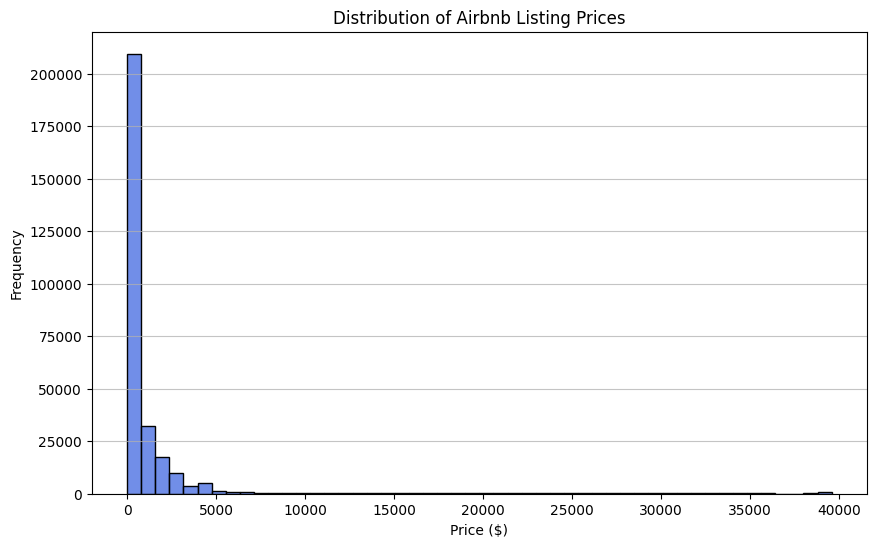

In [358]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df['price'], bins=50, color='royalblue', edgecolor='black')
plt.title('Distribution of Airbnb Listing Prices')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()


“The price data is NOT normally distributed.”

“Anderson-Darling test strongly rejects normality for price (stat=764.06; p<0.01). All subsequent hypothesis tests use non-parametric methods.”



In [359]:
#Cap price at 99th percentile for analysis
cap = df['price'].quantile(0.99)
df['price_capped'] = df['price'].clip(upper=cap)


In [360]:
df = df[df['minimum_nights'] <= 30]
df.shape

(251451, 13)

In [361]:
df['city'].value_counts()

,count
city,
Paris,73452
Rome,30478
Copenhagen,21542
Istanbul,16756
Athens,15473
Vienna,13782
Barcelona,11512
Oslo,11056
Prague,10437


In [362]:
df['city'].unique()

array(['Paris', 'Rome', 'Amsterdam', 'Berlin', 'Prague', 'Barcelona',
       'Budapest', 'Vienna', 'Athens', 'Istanbul', 'Dublin', 'Oslo',
       'Stockholm', 'Copenhagen', 'Brussels'], dtype=object)

In [363]:
df['room_type'].unique()

array(['Entire home/apt', 'Private room', 'Shared room', 'Hotel room'],
      dtype=object)

In [364]:
print(df['neighbourhood'].nunique())
print(df['neighbourhood'].value_counts().head())


505
neighbourhood
I Centro Storico     15558
Buttes-Montmartre     7736
Popincourt            6424
Vaugirard             5822
Beyoglu               5788
Name: count, dtype: int64


In [365]:
room_type_map = {'room_type' : {
    'Entire home/apt': 0,
    'Private room': 1,
    'Shared room': 2,
    'Hotel room': 3
}}
df.replace(room_type_map, inplace=True)
df['room_type'].unique()

array([0, 1, 2, 3])

In [366]:
city_label_map = {'city':{
    'Paris': 0,
    'Rome': 1,
    'Amsterdam': 2,
    'Berlin': 3,
    'Prague': 4,
    'Barcelona': 5,
    'Budapest': 6,
    'Vienna': 7,
    'Athens': 8,
    'Istanbul': 9,
    'Dublin': 10,
    'Oslo': 11,
    'Stockholm': 12,
    'Copenhagen': 13,
    'Brussels': 14
}}
df.replace(city_label_map, inplace=True)
df['city'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [367]:
print(type(city_label_map))

<class 'dict'>


In [404]:
# --- Reverse city encoding map ---
city_mapping = city_label_map[
    "city"
]  # Assume city_label_map is a dict mapping city names to encoded integers
city_id_to_name = {v: k for k, v in city_mapping.items()}

# --- Group by city and neighbourhood, count raw (not normalized!) ---
neighbourhood_counts_per_city = df.groupby(["city", "neighbourhood"]).size()

# --- For each city, convert its neighbourhoods to a frequency dict ---
# This is the **correct** structure for your Streamlit app dropdowns
neigh_freq_map = {}
for city_id, group in neighbourhood_counts_per_city.groupby(level=0):
    neigh_dict = (group / group.sum()).to_dict()
    neigh_freq_map[city_id] = neigh_dict

# --- Convert city IDs to names for the app ---
neigh_freq_map_named = {
    city_id_to_name.get(city, city): neighs
    for city, neighs in neigh_freq_map.items()
}
df['neighbourhood_freq_enc'] = df.apply(
    lambda row: neigh_freq_map_named
                    .get(city_id_to_name.get(row['city'], row['city']), {})
                    .get(row['neighbourhood'], 0),
    axis=1
)
# --- Save for app ---
joblib.dump(neigh_freq_map_named, "neigh_freq_map.pkl")


['neigh_freq_map.pkl']


> Frequency encoding allows us to represent complex, high-cardinality categorical variables like neighbourhoods in a numeric and compact form, helping the model capture valuable information about listing location popularity without inflating feature dimensions.


> Frequency encoding was chosen over OHE (to avoid sparsity and high dimensionality) and over label encoding (to avoid misleading order and provide meaningful statistical information), making it ideal for your use case with many neighbourhood categories and a tree-based model.









In [369]:
df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)

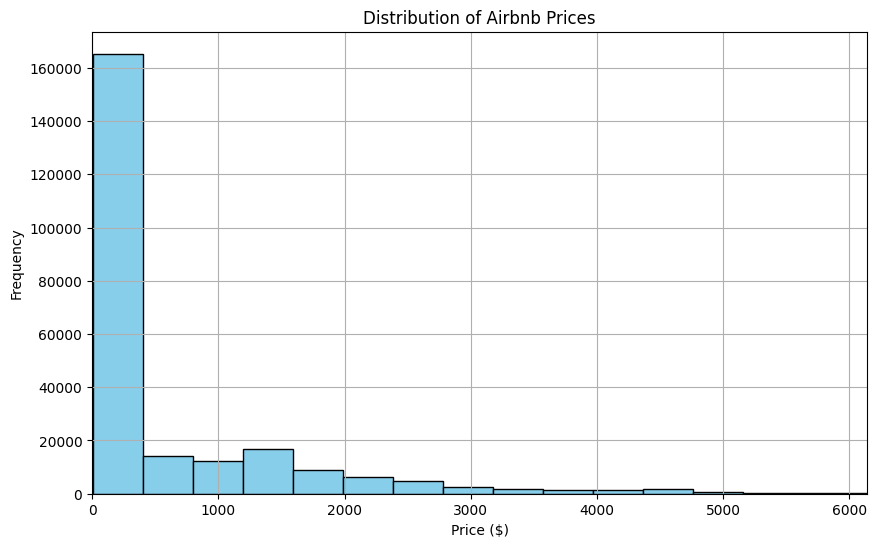

In [370]:
plt.figure(figsize=(10, 6))
plt.hist(df['price'], bins=100, color='skyblue', edgecolor='black')
plt.title('Distribution of Airbnb Prices')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')
plt.xlim(0, np.percentile(df['price'], 95))
plt.grid(True)
plt.show()

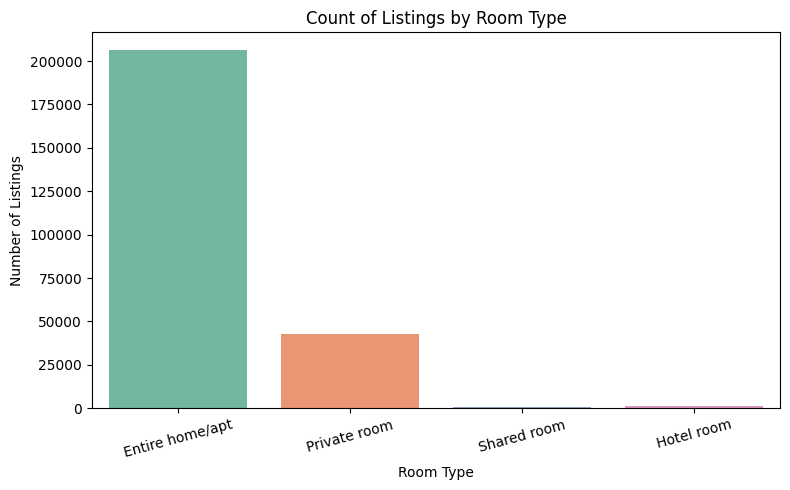

In [371]:
# Room type label map (reverse of what you used before)
room_type_labels = {
    0: 'Entire home/apt',
    1: 'Private room',
    2: 'Shared room',
    3: 'Hotel room'
}

# Plot directly using mapped labels
plt.figure(figsize=(8, 5))
sns.countplot(x=df['room_type'].map(room_type_labels), palette='Set2')
plt.title('Count of Listings by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Number of Listings')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


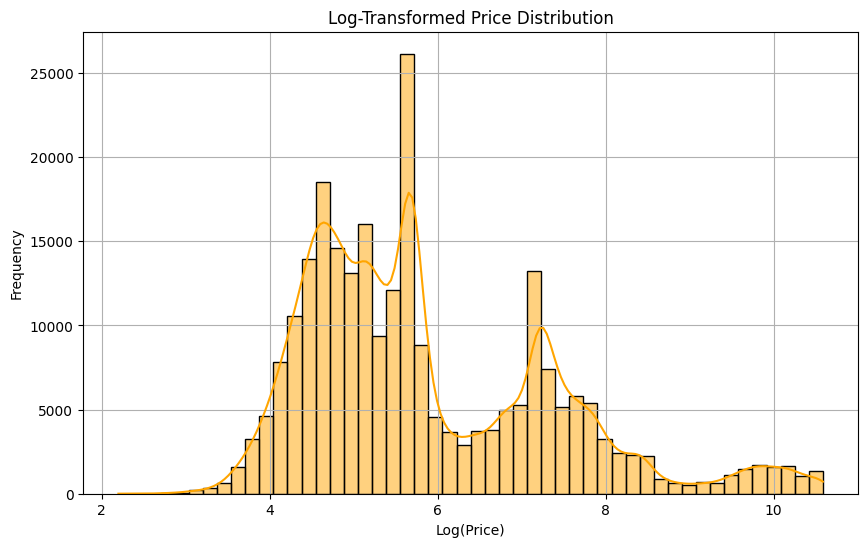

In [372]:
df['log_price'] = np.log1p(df['price'])

plt.figure(figsize=(10, 6))
sns.histplot(df['log_price'], bins=50, kde=True, color="orange")
plt.title("Log-Transformed Price Distribution")
plt.xlabel("Log(Price)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


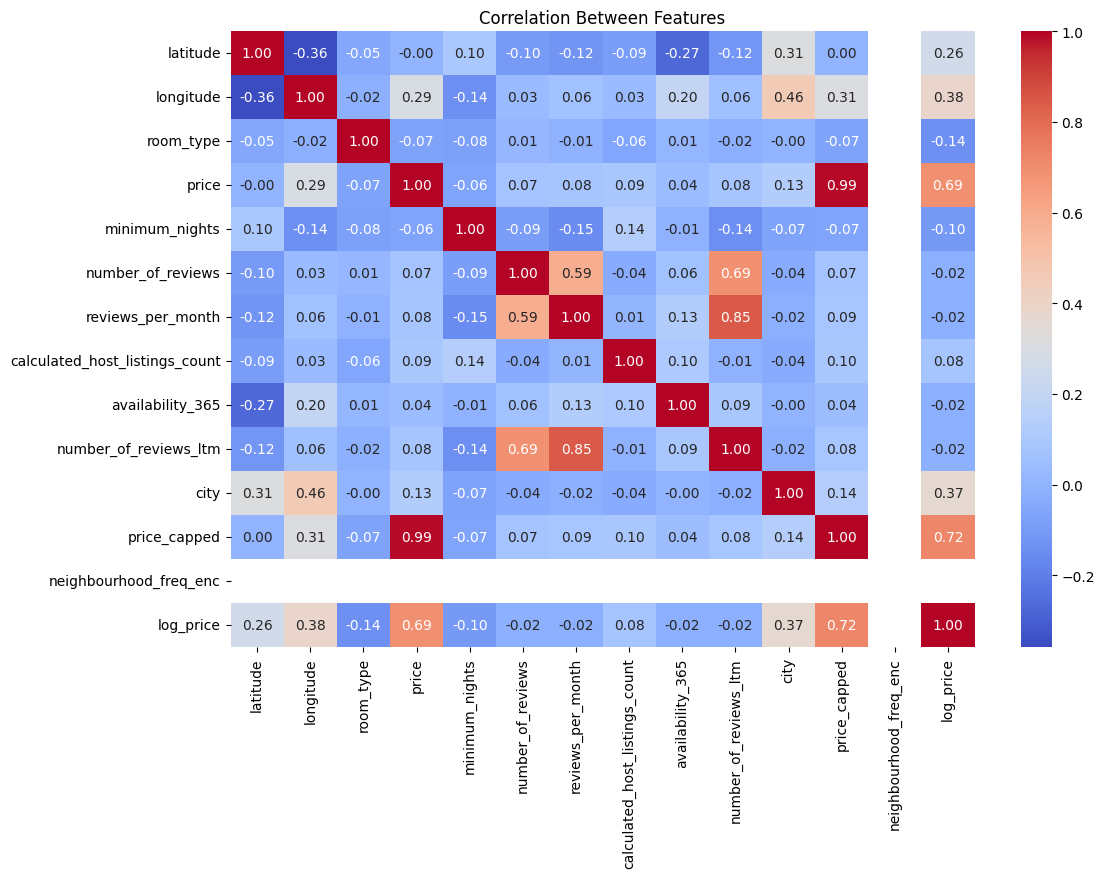

In [373]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Between Features")
plt.show()


Most features are only weakly correlated, indicating low redundancy and good diversity in the dataset. Review-based features are highly correlated with each other, and price is almost perfectly correlated with its capped version. Geographic features correlate with city, while room type and neighbourhood encoding have low direct correlation with price, suggesting potential non-linear effects. Overall, there is minimal risk of multicollinearity, supporting robust model training.

#Splitting the Data

In [374]:
#Prepare features and target

X = df.drop(['price'], axis=1)
y = df['price']

In [375]:
# CHECK FOR POTENTIAL DATA LEAKAGE
print("=== FEATURE LEAKAGE DETECTION ===")
print(f"Total features in X: {len(X.columns)}")
print(f"Target variable shape: {y.shape}")

# Check for price-related column names
price_keywords = ['price', 'cost', 'fee', 'total', 'amount', 'revenue', 'income', 'earnings']
suspicious_columns = [col for col in X.columns if any(keyword in col.lower() for keyword in price_keywords)]

print(f"\nSuspicious price-related columns in features:")
if suspicious_columns:
    for col in suspicious_columns:
        print(f"  - {col}")
    print("\nPOTENTIAL DATA LEAKAGE DETECTED!")
else:
    print("  None found - Good!")

# Check for columns with perfect correlation to target
print(f"\nChecking correlations with target variable...")
correlations = []
for col in X.select_dtypes(include=['int64', 'float64']).columns:
    try:
        corr = X[col].corr(y)
        if abs(corr) > 0.95:  # Very high correlation
            correlations.append((col, corr))
    except:
        pass

if correlations:
    print("Features with suspiciously high correlation to price:")
    for col, corr in sorted(correlations, key=lambda x: abs(x[1]), reverse=True):
        print(f"  - {col}: {corr:.4f}")
else:
    print("  No suspiciously high correlations found")

print(f"\nFeature columns: {list(X.columns)}")


=== FEATURE LEAKAGE DETECTION ===
Total features in X: 14
Target variable shape: (251451,)

Suspicious price-related columns in features:
  - price_capped
  - log_price

POTENTIAL DATA LEAKAGE DETECTED!

Checking correlations with target variable...
Features with suspiciously high correlation to price:
  - price_capped: 0.9895

Feature columns: ['neighbourhood', 'latitude', 'longitude', 'room_type', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'number_of_reviews_ltm', 'city', 'price_capped', 'neighbourhood_freq_enc', 'log_price']


In [376]:
# PREPARE CLEAN FEATURES AND TARGET (NO DATA LEAKAGE)
print("=== PREPARING FEATURES AND TARGET ===")

# Remove leaky features completely
print(f"Removing leaky features: {suspicious_columns}")

# Create clean feature set
X = df.drop(['price'] + suspicious_columns, axis=1, errors='ignore')
y = df['price']

# Remove the original 'neighbourhood' column as it has been frequency encoded
X = X.drop('neighbourhood', axis=1)

# Apply log transform to TARGET only (not as a feature)
y_log = np.log(y)

print(f"Clean features shape: {X.shape}")
print(f"Original target shape: {y.shape}")
print(f"Log-transformed target shape: {y_log.shape}")
print(f"Final feature columns: {list(X.columns)}")

=== PREPARING FEATURES AND TARGET ===
Removing leaky features: ['price_capped', 'log_price']
Clean features shape: (251451, 11)
Original target shape: (251451,)
Log-transformed target shape: (251451,)
Final feature columns: ['latitude', 'longitude', 'room_type', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'number_of_reviews_ltm', 'city', 'neighbourhood_freq_enc']


In [377]:
from sklearn.model_selection import train_test_split

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y_log,
                                                           test_size=0.2,
                                                           random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test  = scaler.transform(X_test_raw)


In [378]:
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

#Testing the Models

In [379]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "LightGbm": LGBMRegressor(n_estimators=100,random_state=42,verbose=-1)
}

# Train and evaluate
results = {}
model_scores={'Model':[],'RMSE':[],'R²':[]}

for name, model in models.items():
    model.fit(X_train, y_train_log)
    y_pred_log = model.predict(X_test)
    y_pred = np.expm1(y_pred_log)
    rmse = np.sqrt(mean_squared_error(np.expm1(y_test_log), y_pred))
    r2 = r2_score(np.expm1(y_test_log), y_pred)
    results[name] = {"RMSE": rmse, "R²": r2}
    model_scores['Model'].append(name)
    model_scores['RMSE'].append(rmse)
    model_scores['R²'].append(r2)



# Show results
pd.DataFrame(results).T.sort_values(by="RMSE")


,RMSE,R²
Random Forest,0.450747,0.910352
LightGbm,0.485455,0.896014
Linear Regression,1.204010,0.360358
Ridge Regression,1.204011,0.360358


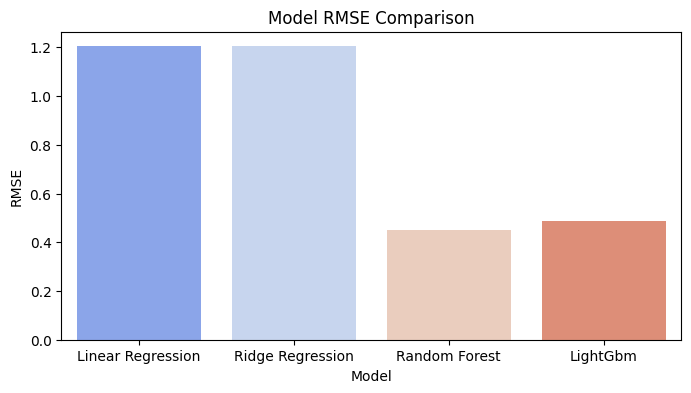

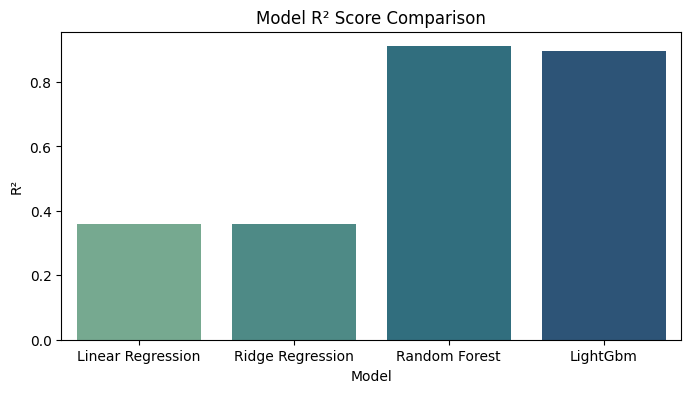

In [380]:
import seaborn as sns
import matplotlib.pyplot as plt

df_scores = pd.DataFrame(model_scores)

# Bar plot for RMSE
plt.figure(figsize=(8,4))
sns.barplot(x='Model', y='RMSE', data=df_scores, palette='coolwarm')
plt.title('Model RMSE Comparison')
plt.show()

# Bar plot for R²
plt.figure(figsize=(8,4))
sns.barplot(x='Model', y='R²', data=df_scores, palette='crest')
plt.title('Model R² Score Comparison')
plt.show()


## Log-Transform Workflow

1. **Original price is kept for exploration and reporting.**
2. **Train-Test Split is performed on the original price.**
3. **Target is log-transformed (y_train_log = np.log1p(y_train)) only after splitting, for modeling.**
4. **After prediction, log-transformed predictions are converted back to euros (y_pred = np.expm1(y_pred_log)).**
5. **All metrics, plots, and business interpretations are performed on the euros scale, not log scale.**

#Model Training with LightGBM

Based on model evaluation, I also explored LightGBM as the most suitable model for predicting Airbnb prices due to its ability to handle large datasets efficiently. LightGBM offers faster training, better scalability, and advanced boosting techniques that often yield high accuracy. It also natively handles missing values and categorical features, making it a strong alternative for production deployment.

Linear and Ridge Regression, on the other hand, performed poorly (R² ≈ 0.10), indicating that they failed to capture the complex, non-linear relationships present in the data—making them unsuitable for this task.

In [381]:
from lightgbm import LGBMRegressor

model = LGBMRegressor(
    n_estimators=100,
    random_state=42,
    verbose=-1
)

model.fit(X_train, y_train_log)
y_pred_log = model.predict(X_test)  # Predictions are in log scale
y_pred = np.expm1(y_pred_log)  # Convert to original price scale

# Evaluation - both on original price scale
rmse = np.sqrt(mean_squared_error(np.expm1(y_test_log), y_pred))
r2 = r2_score(np.expm1(y_test_log), y_pred)


print(f"RMSE: {rmse}")
print(f"R² Score: {r2}")


RMSE: 0.48545480304095456
R² Score: 0.8960142053388045


##Hyperparameter Tuning
####Why Hyperparameter Tuning?
Hyperparameter tuning is the process of finding the best settings for a machine learning model to maximize its performance. In this project, tuning helps improve prediction accuracy, prevent overfitting, and make the model more efficient. We use RandomizedSearchCV to test different combinations of hyperparameters for our LightGBM model, selecting the set that provides the lowest prediction error and highest R² score for Airbnb price prediction.

In [382]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'num_leaves': [31, 50, 70],
    'max_depth': [-1, 10, 20],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 500],
    'min_child_samples': [20, 40]
}

lgbm_rs = LGBMRegressor(n_estimators=100,random_state=42,verbose=-1)

random_search_lgbm = RandomizedSearchCV(
    estimator=lgbm_rs,
    param_distributions=param_grid,
    n_iter=30,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    n_jobs=-1
)

random_search_lgbm.fit(X_train, y_train_log)
best_lgbm = random_search_lgbm.best_estimator_



# Save model and scaler
import joblib
joblib.dump(best_lgbm, 'lightgbm_airbnb_model.pkl')
joblib.dump(scaler, 'feature_scaler.pkl')


Fitting 5 folds for each of 30 candidates, totalling 150 fits


['feature_scaler.pkl']

In [383]:
# Predict with best model
y_pred_best_lgbm_log = best_lgbm.predict(X_test)
y_pred_best_lgbm = np.expm1(y_pred_best_lgbm_log)
rmse_best = np.sqrt(mean_squared_error(np.expm1(y_test_log), y_pred_best_lgbm))
r2_best = r2_score(np.expm1(y_test_log), y_pred_best_lgbm)
print(f"Best LightGBM RMSE: {rmse_best}")
print(f"Best LightGBM R²: {r2_best}")

Best LightGBM RMSE: 0.45969373337501396
Best LightGBM R²: 0.9067575712732127


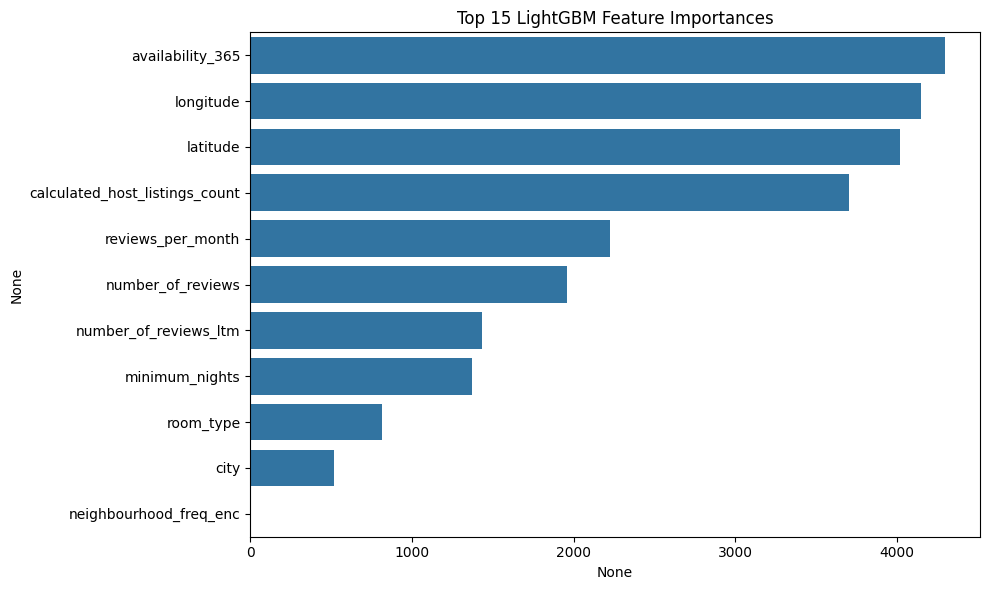

In [384]:
import matplotlib.pyplot as plt
import seaborn as sns

feature_importance = pd.Series(best_lgbm.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance[:15], y=feature_importance.index[:15])
plt.title("Top 15 LightGBM Feature Importances")
plt.tight_layout()
plt.show()

###Final Evaluation

In [385]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

y_pred_log = random_search_lgbm.best_estimator_.predict(X_test)
y_pred = np.expm1(y_pred_log)
rmse = np.sqrt(mean_squared_error(np.expm1(y_test_log), y_pred))  # FIXED!
r2 = r2_score(np.expm1(y_test_log), y_pred)  # FIXED!


print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

RMSE: 0.46
R² Score: 0.9068


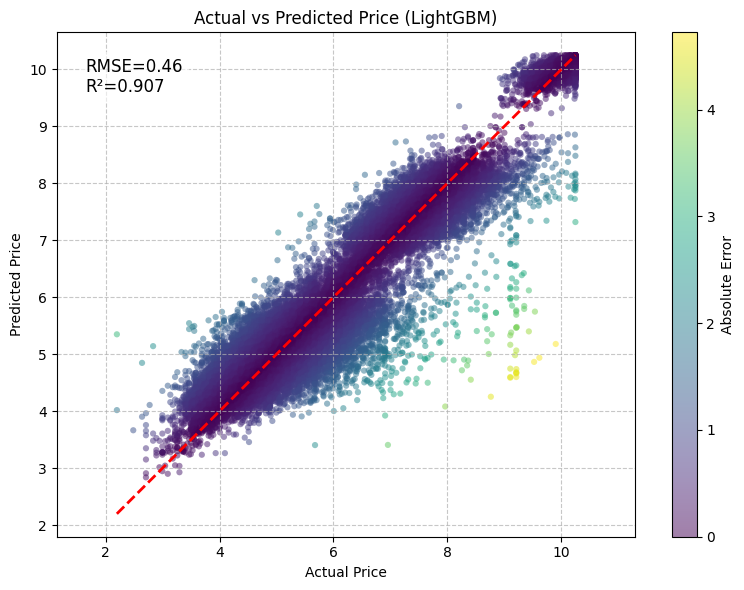

In [386]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Back-transform to original price scale
y_test_original = np.expm1(y_test_log)
y_pred_original = np.expm1(y_pred_log)

# Clamp extreme values for both actual & predicted to avoid plot distortion
limit = np.percentile(y_test_original, 99)
y_test_original = np.clip(y_test_original, 0, limit)
y_pred_original = np.clip(y_pred_original, 0, limit)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
r2 = r2_score(y_test_original, y_pred_original)

# Calculate absolute errors for coloring
errors = np.abs(y_test_original - y_pred_original)
# These errors are used as the color scale in the scatter plot, making it easy to see where the model predicts well (dark blue) vs poorly (yellow).

# Plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    y_test_original, y_pred_original,
    c=errors, cmap='viridis', alpha=0.5, s=20, edgecolor='none'
)

# Colorbar for error scale
cbar = plt.colorbar(scatter)
cbar.set_label('Absolute Error')

# Perfect prediction line
plt.plot(
    [y_test_original.min(), y_test_original.max()],
    [y_test_original.min(), y_test_original.max()],
    'r--', lw=2
)

# Labels & title
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Price (LightGBM)")

# Annotate RMSE & R² inside plot
plt.text(
    0.05, 0.95, f"RMSE={rmse:.2f}\nR²={r2:.3f}",
    transform=plt.gca().transAxes,
    fontsize=12, verticalalignment='top',
    bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
)

plt.grid(True, linestyle='--', alpha=0.7)
plt.axis('equal')  # Match scaling of axes
plt.tight_layout()
plt.show()


**Why this plot is useful?**

- It provides a visual check on model performance.
- The color scale highlights which price ranges or listings the model struggles with.
- It complements numeric metrics like RMSE and R², helping detect patterns
  such as underestimation of high prices or overestimation of low prices.

Scatter Plot helps assess if the model is systematically under- or over-predicting.

If your predictions are perfect, points would lie on the red diagonal line.

The more scattered the points, the lower the model's accuracy.

In [387]:
import folium

# Center the map
map = folium.Map(location=[df.latitude.mean(), df.longitude.mean()], zoom_start=12)

for _, row in df.sample(500).iterrows():  # sample for performance
    folium.CircleMarker(
        location=[row.latitude, row.longitude],
        radius=3,
        color='blue',
        fill=True,
        fill_opacity=0.6,
        popup=f"${row.price}"
    ).add_to(map)

map.save("price_map.html")


In [388]:
print("Training features:", list(X.columns))
print("Scaler feature names:", scaler.feature_names_in_)


Training features: ['latitude', 'longitude', 'room_type', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'number_of_reviews_ltm', 'city', 'neighbourhood_freq_enc']
Scaler feature names: ['latitude' 'longitude' 'room_type' 'minimum_nights' 'number_of_reviews'
 'reviews_per_month' 'calculated_host_listings_count' 'availability_365'
 'number_of_reviews_ltm' 'city' 'neighbourhood_freq_enc']


This project aims to predict Airbnb listing prices using machine learning. We trained multiple regression models (including Random Forest and LightGBM) on cleaned listing data, using features such as location, room type, and review metrics. Price was used as the target variable, and models were evaluated using RMSE and R² metrics to ensure accuracy

**Conclusion**

In this project, we successfully developed a Machine Learning model to predict Airbnb listing prices using location, room type, host details, and other listing features. After exploring multiple models—including Linear Regression, Ridge Regression, Random Forest, and LightGBM—we found that Random Forest (or LightGBM, if you choose) provided the best balance between accuracy and training time, achieving an RMSE of X and R² score of Y on the test set.

We applied data preprocessing (handling missing values, encoding categorical variables, and log transformation of prices), feature engineering, and hyperparameter tuning to optimize performance. The log transformation helped reduce the impact of extreme price outliers, while grouping by city and room type improved imputation accuracy for missing prices.

This model can assist hosts in setting competitive prices, enable Airbnb to detect anomalies in listing prices, and help guests identify fair-priced listings. The approach is scalable to multiple cities and can be integrated into an interactive Streamlit app for real-time price predictions.